## Import libraries

In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gurobipy import *

## Read and preprocess data


In [220]:
import csv
from datetime import datetime
import os

def load_data(file_path):
    data_dict = dict()

    with open(file_path) as file:
        reader = csv.DictReader(file)
        for row in reader:
            if row['Numéro du groupe'] != '':
                heures, minutes, _ = map(int, row['TransitTime'].split(':')) 
                total_minutes = heures * 60 + minutes
                data_dict[int(float(row['Numéro du groupe']))] = (
                    int(float(row['Femmes'])),
                    int(float(row['Hommes'])),
                    int(float(row['WCHR'])),
                    total_minutes
                )

    return data_dict

# Load data for each file

file_names = ["5Nov.csv", "7Nov.csv", "22Oct.csv", "24Oct.csv", "23Oct.csv", "30Oct.csv", "DataSeating 2024.csv"]
data_directory = 'data'
# for eachy dictionary : dict[Numéro du groupe : (Femmes, Hommes, WCHR, TransitTime)]
Nov5, Nov7, Oct22, Oct24, Oct23, Oct30, Date0 = [load_data(os.path.join(data_directory, file)) for file in file_names]

Example of how we access data

In [206]:
Nov5[1][0] # Number of women in group 1 on November 5th

1

Transforming data to access each passenger's Id

First we solved the problem for November 5th, then we'll have to automate it

In [207]:
Passengers = {}
j = 1

for group_num, data in Nov5.items():
    weights = {'Femmes': 70, 'Hommes': 85, 'WCHR': 10000}  # Weight per passenger
    
    # Extracting data
    femmes, hommes, wchr, total_minutes = data
    
    # Enumerating passengers
    for _ in range(femmes + hommes + wchr):
        if femmes > 0:
            weight = weights['Femmes']  
            Passengers[j] = {'gender': 'Femmes', 'group': group_num, 'weight': weight, 'connection_time': total_minutes}
            femmes -= 1
        elif hommes > 0:
            weight = weights['Hommes']
            Passengers[j] = {'gender': 'Hommes', 'group': group_num, 'weight': weight, 'connection_time': total_minutes}
            hommes -= 1
        else:
            weight = weights['WCHR']
            Passengers[j] = {'gender': 'WCHR', 'group': group_num, 'weight': weight, 'connection_time': total_minutes}
            wchr -= 1
        j += 1

print(Passengers)

{1: {'gender': 'Femmes', 'group': 1, 'weight': 70, 'connection_time': 0}, 2: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 3: {'gender': 'Hommes', 'group': 1, 'weight': 85, 'connection_time': 0}, 4: {'gender': 'Hommes', 'group': 2, 'weight': 85, 'connection_time': 60}, 5: {'gender': 'Femmes', 'group': 3, 'weight': 70, 'connection_time': 165}, 6: {'gender': 'Hommes', 'group': 3, 'weight': 85, 'connection_time': 165}, 7: {'gender': 'Femmes', 'group': 4, 'weight': 70, 'connection_time': 0}, 8: {'gender': 'Hommes', 'group': 4, 'weight': 85, 'connection_time': 0}, 9: {'gender': 'WCHR', 'group': 4, 'weight': 10000, 'connection_time': 0}, 10: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 11: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 12: {'gender': 'Femmes', 'group': 5, 'weight': 70, 'connection_time': 0}, 13: {'gender': 'Femmes', 'group': 6, 'weight': 70, 'connection_time': 0}, 14: {'gender': 'Hommes', 'group': 6, 'we

## Static model

In [208]:
ranks = 29 #number of rows in the aircraft
n = len(Passengers) #number of passengers - TO BE CHANGED
ns=7*ranks #number of seats

def modele_statique():
    m=Model('statique') # Model initialization
    
    # -- Adding variables  --
    # Sij : dict[(int, int) : Var] : Associate passenger i with seat j
    S = {(i,j) : m.addVar(vtype = GRB.BINARY, name = f'j{i}') for i in range(1, n+1) for j in range (1, ns+1)}

    

    # -- Adding constraints  --
    
    # Max. 1 seat per passenger
    for j in range (1, ns+1):
        m.addConstr(quicksum(S[(i,j)] for i in range (1, n+1)) <=1, name="PassengerMax")

    #Each passenger has one and only one seat
    for i in range (1, n+1):
        m.addConstr(quicksum(S[(i,j)] for j in range (1, ns+1)) == 1, name="SeatMax")
        
    #The central aisle is left free   
    for i in range (1, n+1):
        for j in range (1, ns+1):
            if j%7==4 : 
                m.addConstr(S[(i, j)] == 0)

     #Baricenter
    
    x_g = LinExpr()
    y_g = LinExpr()

    total_weight = quicksum(Passengers[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        
        j_k=1

        for j in range(1, ns + 1):
            
            weight_ij = Passengers[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k=j_k+1
         

            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7)  + 1 )* S[i, j] * weight_ij)
                
    

    m.addConstr(x_g >= 3)  
    m.addConstr(x_g <= 5)  
    
    m.addConstr(y_g >= 13)  
    m.addConstr(y_g <= 17)


    #Passagers handicapés occupent 4 places collées à l'allée centrale
    for passenger in Passengers:
        if Passengers[passenger]['gender']=='WCHR':
            for j in range(1, ns+1-8, 7):             #On ârcourt les sièges par rangée (de 7 en 7)
            
                x1, x2, x3, x4, x5, x6, x7 = j, j+1, j+2, j+3, j+4, j+5, j+6
                

                m.addConstr(S[(passenger, x1)] + S[(passenger, x2)] + S[(passenger, x6)] + S[(passenger, x7)] ==0 )   #On fixe un siège dans les rangs 3 ou 5

                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+1)] for i in Passengers) <= 1) #On condamne le siège donnant sur l'allée
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+7)] for i in Passengers) <= 1) #On condamne les 2 sièges derrière
                m.addConstr(S[(passenger, x3)]+sum(S[(i, x3+8)] for i in Passengers) <= 1)
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+1)] for i in Passengers) <= 1) #On condamne le siège donnant sur l'allée
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+7)] for i in Passengers) <= 1) #On condamne les 2 sièges derrière
                m.addConstr(S[(passenger, x5)]+sum(S[(i, x5+8)] for i in Passengers) <= 1)
                
            m.addConstr(sum(S[(passenger, k)] for k in range (ns-6, ns+1)) == 0)  #Un passger handicapé ne peut pas être sur la dernière rangée


    return m, S

In [209]:
m,S=modele_statique()

Fonctions objectifs

In [210]:

#Les passagers en transit sont placés à l'avant de l'avion

def obj_transit():
    T= {} 
    
    for passenger in Passengers:
        if Passengers[passenger]['connection_time'] >0:   #passager en transit
            T[passenger]=Passengers[passenger]['connection_time']

    #T=sorted(T.items(), key=lambda item:item[1], reverse=True)
    P=list(T.keys())  #retourne la liste des identifiants des passagers en transit
    

    f=0
    for k in range (len(P)):
        for j in range (1, ns+1):
            q=(j-1)//7
            f+= S[(P[k],j)] * (1/T[P[k]]) * q
            

    return f

m.setObjective(obj_transit(), GRB.MINIMIZE)

In [211]:
def seat_coordinates(seat):
    coordinates = []
    for j in range(len(seat)):
        if (seat[j] % 7 == 0):
            x = 7
            y = (seat[j] // 7) 
        else:
            x = seat[j] % 7
            y = (seat[j] // 7) +1 
        coordinates.append((x, y))
    return coordinates

In [212]:
alpha=0.8

def obj_dist(alpha):

    obj = LinExpr()
    for i in range(1, n + 1):
        for k in range(i + 1, n + 1):  
            if  i!=k and Passengers[i]['group'] == Passengers[k]['group']:  

                xi, yi = seat_coordinates([j for j in range(1, ns + 1) if S[(i, j)].x])[0]  
                xk, yk = seat_coordinates([j for j in range(1, ns + 1) if S[(k, j)].x])[0]  
                dist_x = abs(xi - xk)  
                dist_y = abs(yi - yk)  
                obj += alpha*dist_x + (1-alpha)*dist_y  
                
    return obj


#m.setObjective(obj_dist(alpha), GRB.MINIMIZE)




In [213]:
# -- Choix d'un paramétrage d'affichage minimaliste --
m.params.outputflag = 0 # mode muet

# -- Mise à jour du modèle  --
m.update() 

# -- Affichage en mode texte du PL --
display(m)

<gurobi.Model MIP instance statique: 3905 constrs, 19691 vars, Parameter changes: Username=(user-defined), OutputFlag=0>

In [214]:
# -- Résolution --
m.optimize()

# -- Affichage de la solution --
print("Les places dans l'avion sont les suivantes :", [(i,j) for i in range(1,n+1) for j in range (1,ns+1) if S[(i,j)].x])

Les places dans l'avion sont les suivantes : [(1, 87), (2, 163), (3, 139), (4, 7), (5, 22), (6, 23), (7, 138), (8, 119), (9, 192), (10, 168), (11, 176), (12, 148), (13, 182), (14, 61), (15, 15), (16, 21), (17, 147), (18, 1), (19, 3), (20, 12), (21, 2), (22, 29), (23, 127), (24, 84), (25, 170), (26, 106), (27, 161), (28, 31), (29, 70), (30, 82), (31, 122), (32, 13), (33, 142), (34, 166), (35, 115), (36, 49), (37, 114), (38, 191), (39, 91), (40, 187), (41, 101), (42, 110), (43, 167), (44, 24), (45, 64), (46, 69), (47, 56), (48, 174), (49, 58), (50, 17), (51, 10), (52, 16), (53, 183), (54, 198), (55, 194), (56, 173), (57, 155), (58, 78), (59, 89), (60, 149), (61, 146), (62, 50), (63, 104), (64, 201), (65, 83), (66, 8), (67, 19), (68, 121), (69, 134), (70, 5), (71, 6), (72, 90), (73, 120), (74, 52), (75, 66), (76, 159), (77, 38), (78, 135), (79, 26), (80, 160), (81, 86), (82, 181), (83, 75), (84, 100), (85, 9), (86, 14), (87, 20), (88, 154), (89, 93), (90, 65), (91, 128), (92, 59), (93, 12

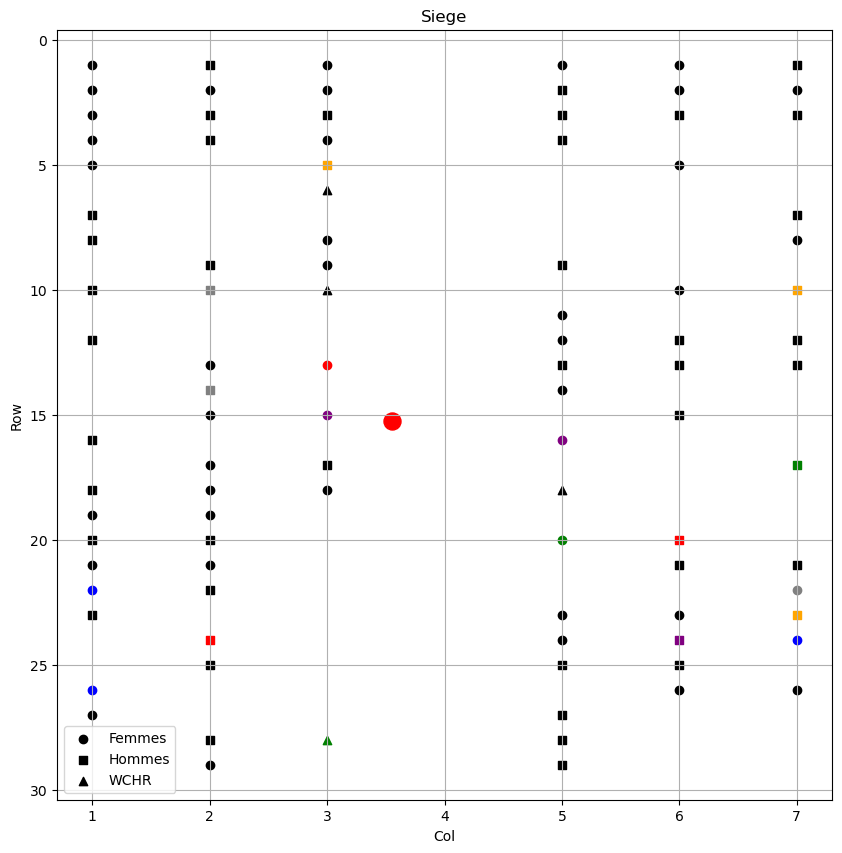

In [219]:
import matplotlib.pyplot as plt
from collections import defaultdict


# Creating a variable called seats containing only the j coordinates
seats = [j for i in range(1, n + 1) for j in range(1, ns + 1) if S[(i, j)].x]
seat_coords = seat_coordinates(seats)


# Display the Baricenter

def calculate_center_of_mass(seat_coords, Passengers):
    x_g = LinExpr()
    y_g = LinExpr()
    total_weight = quicksum(Passengers[i]['weight'] for i in range(1, n + 1)).getValue()

    for i in range(1, n + 1):
        j_k = 1

        for j in range(1, ns + 1):
            weight_ij = Passengers[i]['weight'] / total_weight

            if (j % 7 == 0):
                x_g += (7 * S[i, j] * weight_ij)
                y_g += (j_k * S[i, j] * weight_ij)
                j_k += 1
            else:
                x_g += ((j % 7) * S[i, j] * weight_ij)
                y_g += (((j // 7) + 1) * S[i, j] * weight_ij)

    return x_g, y_g


x_g, y_g = calculate_center_of_mass(seat_coords, Passengers)



# Dictionary to count the frequency of each group
group_counts = defaultdict(int)

# Counting the frequency of each group
for passenger in Passengers.values():
    group_counts[passenger['group']] += 1

# Sort the groups by the number of passengers in each group in descending order
sorted_groups = sorted(group_counts.items(), key=lambda x: x[1], reverse=True)

# Print the groups in ascending order with the number of passengers in each group
#print("Groups in ascending order with the number of passengers in each group:")
#for group, count in sorted_groups:
#    print(f"Group {group}: {count} passengers")

# Define shapes for each gender
shapes = {
    'Femmes': 'o',   # Circule
    'Hommes': 's',   # Square
    'WCHR': '^'      # Triangule
}

# Define colors for the groups with 3 passangers
colors = {
    1: 'red',
    4: 'green',
    5: 'blue',
    14: 'orange',
    23: 'purple',
    46: 'gray'
}


plt.figure(figsize=(10, 10))
for idx, coord in enumerate(seat_coords):
    group = Passengers[idx + 1]['group']
    gender = Passengers[idx + 1]['gender']
    color = colors.get(group, 'black')  # Get color for the group, default to black if not in colors dictionary
    shape = shapes.get(gender, 'o')      # Get shape for the gender, default to circle if not in shapes dictionary
    plt.scatter(coord[0], coord[1], color=color, marker=shape)  # Use marker parameter to set the shape
    
# Add labels for each gender
for gender, shape in shapes.items():
    plt.scatter([], [], color='black', marker=shape, label=gender)  # Create invisible scatter plot to add label

# Plotting the center of mass
plt.scatter(x_g.getValue(), y_g.getValue(), color='red', marker='o', s=150)  # Larger red point for center of mass

plt.xlabel('Col')
plt.ylabel('Row')
plt.title('Siege')
plt.grid(True)
plt.gca().invert_yaxis()
plt.legend()  # Show legend with gender labels
plt.show()
